In [38]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as lm
import numpy as np
np.random.seed(1555)
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Reshape,Dropout,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU,PReLU,SReLU
from keras.callbacks import EarlyStopping

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

from keras.regularizers import l1,l2
from keras.constraints import nonneg

%matplotlib inline
import tensorflow
import keras
import math
import time
import datetime
from sklearn import cluster, datasets, metrics


from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [66]:
oli = pd.read_csv('cleanoutwvd.csv')
olier = oli.copy();
#去掉當量暫時不用

# olier.speed=(olier.speed);olier
# olier.YY=olier.YY-16;
olier=olier.drop(['YY','day','date','time','direct','lane','eqflow','fakeornot','realvd'],axis=1);olier
# olier['serial'] = olier.index

#StandardScaler 標準化


olierc=StandardScaler().fit_transform(olier)

# mean zero 標準化 目前最好
# olierc = preprocessing.scale(olier)
olierc=pd.DataFrame(olierc,columns=['sortby','speed','accu'])

# max min 標準化
# scaler = MinMaxScaler(feature_range=(0, 1))
# olier = scaler.fit_transform(olier)

# olierc=pd.DataFrame(olier,columns=['sortby','speed','accu'])

olierclo = olierc.columns.tolist()
olierc=olierc[olierclo[:-2]+olierclo[-1:]+olierclo[-2:-1]]


# olierc = olier.copy()
# somin = olier.sortby.min().copy()
# somax = olier.sortby.max().copy()-somin;
# olierc.sortby = ((olierc.sortby-somin)/(somax));olierc


# #佔有率標準化
# dfmin = olier.accu.min().copy()
# mxmin = olier.accu.max().copy()-dfmin;
# olierc.accu = ((olierc.accu-dfmin)/(mxmin));olierc

# #佔有率標準化

# dfminspeed = olier.speed.min().copy()
# mxminspeed = olier.speed.max().copy()-dfminspeed;
# olierc.speed = ((olierc.speed-dfminspeed)/(mxminspeed));olierc





#0225version
def cleanout(inp,i):
    dfvdi= inp.where(inp['sortby']==i).dropna();

    outp = dfvdi.copy()
    # 某個時間要把fakeornot去掉 
    outpp = outp.values.astype('float32')
    # 分出train 跟test
    train_size = int(len(outpp) * 0.75)
    test_size = len(outpp) - train_size
    train, test = outpp[0:train_size,:], outpp[train_size:len(outpp),:]
    if (len(train)%168 != 0) or (len(test)%168 != 0) :
        train=train[:-(len(train)%168)]
        test=test[:-(len(test)%168)]
        
    return train,test


import time
start = time.time()

sortbylist=olierc['sortby'].unique().tolist()
# goodone_i_think
sortbylist2=[sortbylist[4],sortbylist[8],sortbylist[3]]
# soso list
# sortbylist3=[sortbylist[5],sortbylist[10],sortbylist[17],sortbylist[18],sortbylist[26],sortbylist[27],sortbylist[28]\
#             ,sortbylist[35],sortbylist[36],sortbylist[37],sortbylist[39],sortbylist[42],sortbylist[49],sortbylist[38]]

# bad list
# sortbylist4=[sortbylist[0],sortbylist[1],sortbylist[2],sortbylist[7],sortbylist[9],sortbylist[11],sortbylist[12]\
#             ,sortbylist[13],sortbylist[14],sortbylist[15],sortbylist[16],sortbylist[19],sortbylist[20]\
#             ,sortbylist[21],sortbylist[22],sortbylist[23],sortbylist[24],sortbylist[25],sortbylist[30]\
#             ,sortbylist[31],sortbylist[32],sortbylist[33],sortbylist[34],sortbylist[40],sortbylist[41]\
#             ,sortbylist[43],sortbylist[44],sortbylist[45],sortbylist[46],sortbylist[47],sortbylist[50]]



tralist = []
teslist = []

for i in sortbylist2:
    temptra,temptes=cleanout(olierc,i)
    #train
    for ele in temptra.tolist():
        tralist.append(ele)
    #test
    for ele3 in temptes.tolist():
        teslist.append(ele3)

cluster01tra=np.array(tralist)
print len(cluster01tra)
cluster01tes=np.array(teslist)
print len(cluster01tes)

# cluster01tra = preprocessing.scale(cluster01tra)
# cluster01tes = preprocessing.scale(cluster01tes)

print(start - time.time()),'seconds'



15120
5040
-0.099515914917 seconds


In [57]:
import time
start = time.time()
#起始隨機子

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-1,look_back):
        a = dataset[i:(i+look_back), 0:nort]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i+look_back+look_back, nort-1])
#     return dataX,dataY
    return np.array(dataX), np.array(dataY)

# 看資料有幾個欄位就寫幾
nort = 3
# magic number
look_back = 168
# cut off remainder
train = cluster01tra
test = cluster01tes
# check data lenth when cut off remainder
print(len(train), len(test))

# seperate data to input"X" and output"Y"
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
    
# create and fit Multilayer Perceptron model
model = Sequential()
# model = Model(input=look_back*nort,output=[look_back,2])

# RESHAPE is  working !!!!! >0<"
model.add(Reshape((look_back*nort,), input_shape=(look_back,nort)))

# Add layers to neruon network
# model.add(Dropout(0.3))
model.add(MaxoutDense(306,input_dim=(look_back*nort)))
model.add(LeakyReLU(0.00017))
model.add(Dropout(0.2))
model.add(Dense(256, init='uniform',W_regularizer = l2(0.00017), activation='relu'))
model.add(LeakyReLU(0.00017))
# model.add(Dropout(0.2))
# model.add(Dense(256, init='he_normal',W_regularizer = l2(0.0000017), activation='linear'))
# model.add(LeakyReLU(0.00017))
# model.add(Dropout(0.2))
model.add(MaxoutDense(256, init='uniform',W_regularizer = l2(0.000017)))
model.add(LeakyReLU(0.00017))
model.add(Dropout(0.2))
model.add(Dense(look_back, activation='linear',W_regularizer = l2(0.000017)))
model.compile(loss='mse', optimizer='adam')

# ,metrics=['accuracy']

model.fit(trainX, trainY, nb_epoch=512, batch_size=256, verbose=0)
#for earlystopping
# model.fit(trainX, trainY, batch_size=8, nb_epoch=1024, verbose=0,validation_split=0.3,callbacks=[earlyStopping])


#,validation_split=0.3,callbacks=[earlyStopping]

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
# print('Train Score: %.2f MAPE ' % trainScore)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
# print("Train Score: %.2f CCE" % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
# print('Test Score: %.2f MAPE ' % testScore)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# print("Test Score: %.2f CCE" % (testScore))


print(start - time.time()),'seconds'


(15120, 5040)
Train Score: 0.02 MSE (0.13 RMSE)
Test Score: 0.83 MSE (0.91 RMSE)
-44.6391530037 seconds


In [52]:
# model.save('model0309.h5')

In [53]:
# model=load_model('model0309.h5')

-0.25013
-0.321991712189
0.619935
0.566071991278


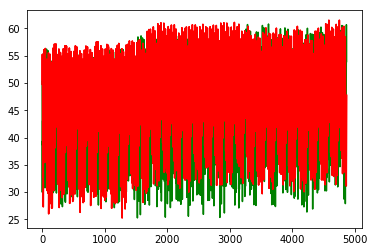

In [78]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# pre = trainPredict.reshape(len(trainPredict)*len(trainPredict[0]),)
# ori = trainY.reshape(len(trainY)*len(trainY[0]),)


pre = testPredict.reshape(len(testPredict)*len(testPredict[0]),)
ori = testY.reshape(len(testY)*len(testY[0]),)

print pre.mean()
print ori.mean()
print pre.std()
print ori.std()

prede = StandardScaler().fit(olier.speed.values.reshape(-1,1)).inverse_transform(pre)
oride = StandardScaler().fit(olier.speed.values.reshape(-1,1)).inverse_transform(ori)

plt.plot(prede,color='r')
plt.plot(oride,color='g')
plt.plot(prede,color='r')



# plt.plot(ori[5000:5168],color='g')
# plt.plot(pre[5000:5168],color='r')

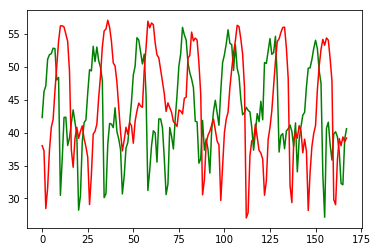

In [79]:
# plt.plot(ori[600:768],color='g')
# plt.plot(pre[600:768],color='r')

# # plt.plot(ori[4995:5163],color='g')
plt.plot(oride[1000:1168],color='g')
plt.plot(prede[1000:1168],color='r')

In [193]:
i=8
olieri=olier[olier.sortby==i]

thisweek=olieri.reset_index().drop('index',axis=1).ix[6552:6719,:]



thisweekno=StandardScaler().fit(olier).transform(thisweek)
model=load_model('model0309.h5')
nextweek = model.predict(np.array([thisweekno.tolist()]))


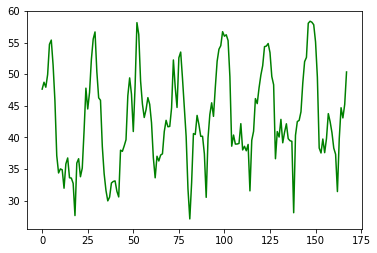

In [195]:
nextweekori=olieri.reset_index().drop('index',axis=1).ix[6720:,:].reset_index()
nextweekp = StandardScaler().fit(olier.speed.values.reshape(-1,1)).inverse_transform(nextweek[0])
plt.plot(nextweekori.speed,color='g')
# plt.plot(nextweekp,color='r')
# plt.plot(thisweek.speed.values,color='b')

In [189]:
# oli[oli.sortby==3].reset_index().drop('index',axis=1).ix[6552:6719,:]
# oli[oli.sortby==3].reset_index().drop('index',axis=1).ix[6720:,:]

In [188]:
pre=pd.DataFrame(nextweekp,columns=['speed'])
pre['time']=oli[oli.sortby==3].reset_index().drop('index',axis=1).ix[6552:6719,:].reset_index().time
pre['day'] = oli[oli.sortby==3].reset_index().drop('index',axis=1).ix[6552:6719,:].reset_index().day
pre

,speed,time,day
0,50.835419,0,4
1,54.362923,1,4
2,59.195694,2,4
3,60.017838,3,4
4,58.979218,4,4
5,55.310062,5,4
6,53.422024,6,4
7,47.085384,7,4
8,37.037266,8,4
9,33.054157,9,4


In [92]:
thisweek

,sortby,speed,accu
6553,4.0,50.695366,1.920000
6554,4.0,52.864143,1.180000
6555,4.0,53.714540,0.915000
6556,4.0,53.943493,0.725000
6557,4.0,54.142820,0.785000
6558,4.0,52.109570,1.305000
6559,4.0,45.359100,5.180000
6560,4.0,35.380780,16.610000
6561,4.0,36.291560,16.790000
6562,4.0,36.520380,15.380001
